In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
# Read csv files
train_df = pd.read_csv("DailyDelhiClimateTrain.csv", parse_dates=True,index_col='date')
test_df = pd.read_csv("DailyDelhiClimateTest.csv", parse_dates=True,index_col='date')

#### Lag  concept
Lags refer to previous values of a variable used to predict or analyze its future values. Essentially, a lag represents a delay in the variable's behavior over time, and it helps capture dependencies between past observations and current or future observations.

Example explained in the below code

In [4]:
train_df['meantempL1'], train_df['meantempL2'], train_df['meantempL3'] , train_df['meantempL4']= (
    train_df['meantemp'].shift(1), train_df['meantemp'].shift(2), train_df['meantemp'].shift(3),train_df['meantemp'].shift(4)
)

print(
    '\n',train_df['meantempL1'].corr(train_df['meantemp']),
    '\n',train_df['meantempL2'].corr(train_df['meantemp']),
    '\n',train_df['meantempL3'].corr(train_df['meantemp']),
    '\n',train_df['meantempL4'].corr(train_df['meantemp'])
)
## The predictive power decreases until it can't predict bo more


 0.9740674782673885 
 0.9565129344496726 
 0.9426231725006877 
 0.9350764922644199


The predictive power decreases until it can't predict no more

To demonstate this we'll plot an Autocorrelation function(ACF) plot

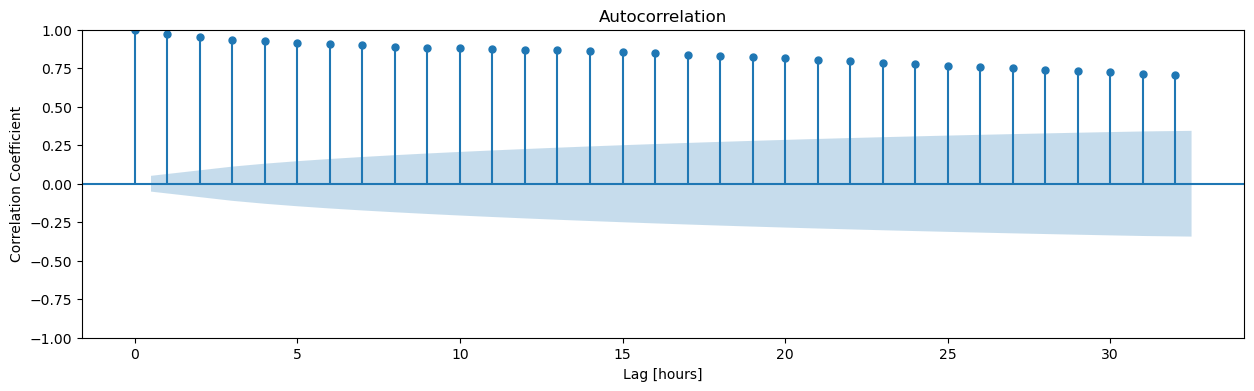

In [5]:
fig, ax = plt.subplots(figsize=(15, 4))
plot_acf(train_df['meantemp'], ax = ax)

plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

To see which lags have strong predictive power we plot a (partial autocorrelation function)PACF 

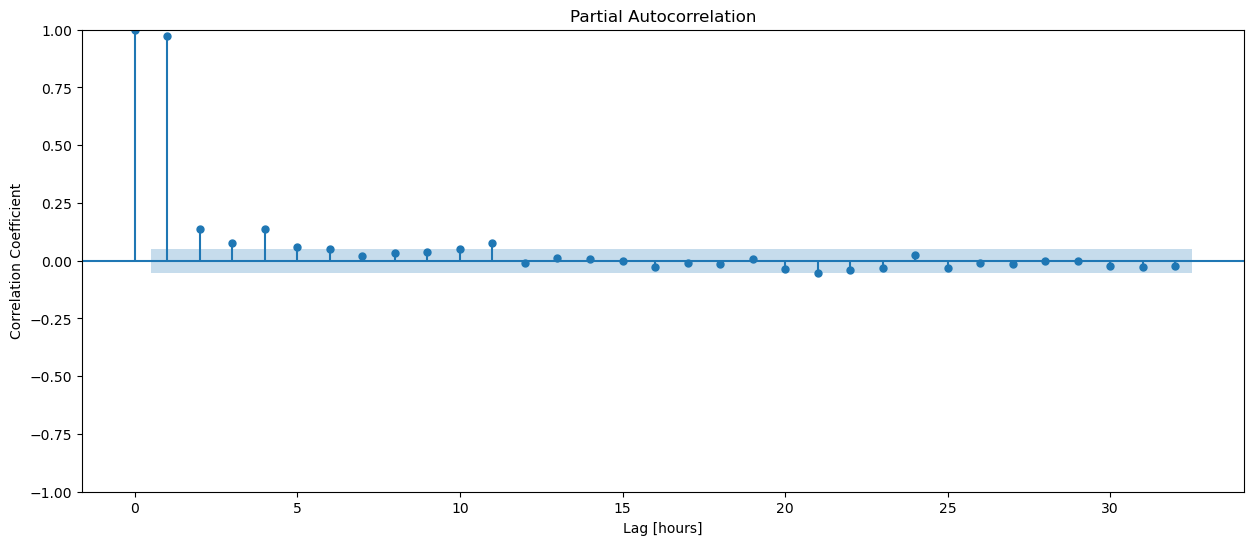

In [6]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(train_df['meantemp'], ax = ax)

plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

## Beyond 4 everything is due to chance 

### Build model

In [7]:
train_df.head()

,meantemp,humidity,wind_speed,meanpressure,meantempL1,meantempL2,meantempL3,meantempL4
date,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,NaN,NaN,NaN,NaN
2013-01-02,7.400000,92.000000,2.980000,1017.800000,10.000000,NaN,NaN,NaN
2013-01-03,7.166667,87.000000,4.633333,1018.666667,7.400000,10.000000,NaN,NaN
2013-01-04,8.666667,71.333333,1.233333,1017.166667,7.166667,7.400000,10.0,NaN
2013-01-05,6.000000,86.833333,3.700000,1016.500000,8.666667,7.166667,7.4,10.0


In [8]:
# Set the frequency explicitly to daily ('D')
train_df = train_df.asfreq('D')

train_df['meantemp'] = train_df['meantemp'].squeeze()
train_df['meantemp'].index = pd.to_datetime(train_df['meantemp'].index) 
model = AutoReg(train_df['meantemp'], lags = 4).fit()

In [9]:
## Calculate the mean absolute error of or preciction
y_pred = model.predict()
training_mae = mean_absolute_error(train_df['meantemp'].iloc[4:], y_pred.dropna())
print("Training MAE:", training_mae)

Training MAE: 1.2230699087323427


In [10]:
### Since this is a linear model we'll have a look at the residual distribution
resid_ = model.resid

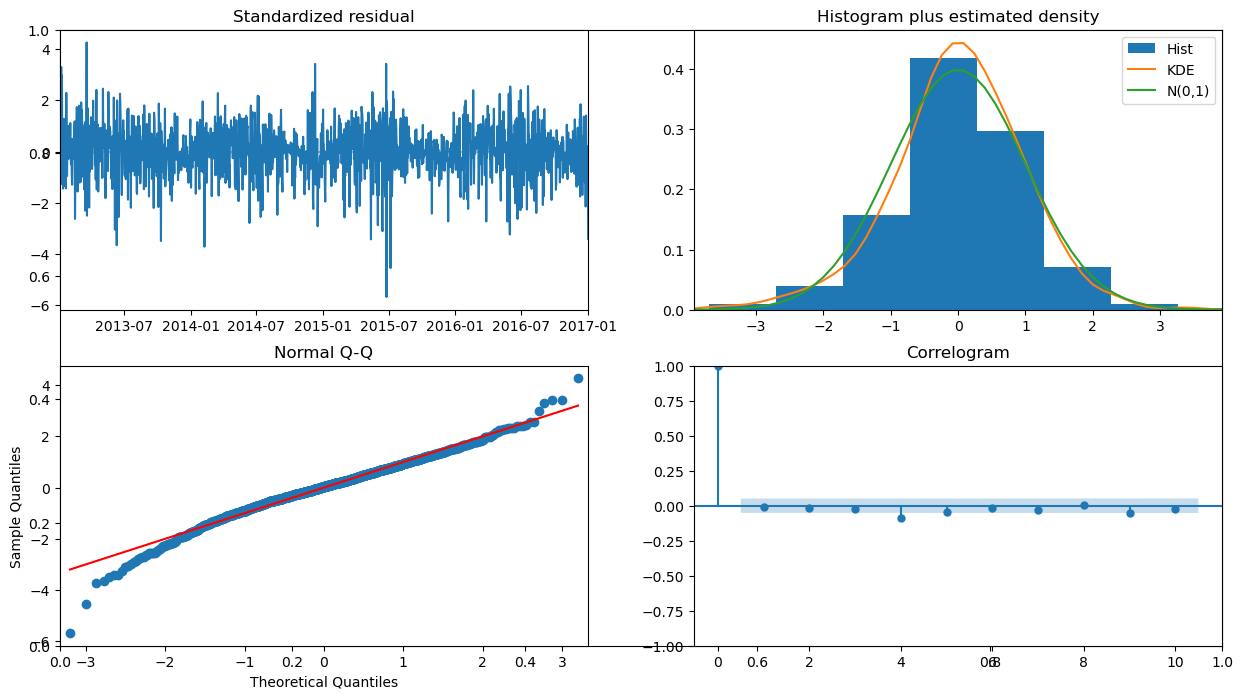

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))
model.plot_diagnostics(fig = fig);

### Interpratation of the above plot.
1. Standardized Residuals Plot:
Residuals appear to have a mean close to zero and no discernible pattern or trend over time.

2.  Histogram plus Estimated Density:
This is a histogram of the residuals, overlaid with two density curves
The residuals seem to approximate a normal distribution fairly 
The distribution of residuals are close to normal bell curve

3. Normal Q-Q Plot:
The points should fall on or close to the red line.

4. Correlogram:
Residuals(ACF) plot
The residuals do not exhibit any significant autocorrelation — they are uncorrelated with each other

Basically our model is doing fairly a descent job

### Evaluate

In [12]:
# Set the frequency explicitly to daily ('D')
train_df = train_df.asfreq('D')

test_df['meantemp'] = test_df['meantemp'].squeeze()
test_df['meantemp'].index = pd.to_datetime(test_df['meantemp'].index)

y_pred_test = model.predict(test_df['meantemp'].index.min(), test_df['meantemp'].index.max())
test_mae = mean_absolute_error(test_df['meantemp'], y_pred_test)
print("Test Mean Absolute Error:", test_mae)

### This is way above our baseline MAE

Test Mean Absolute Error: 4.116904127470226


In [13]:
pred_test_df = pd.DataFrame(
    {
    "test": test_df['meantemp'], 
     "pred": model.predict(start = test_df['meantemp'].index[0],end=test_df['meantemp'].index[-1])
     },index = test_df['meantemp'].index
)

fig = px.line(pred_test_df, labels={"value": "P2"})
fig.show();

In [14]:
print(train_df['meantemp'].tail(1))
print(test_df['meantemp'].head(2))

date
2017-01-01    10.0
Freq: D, Name: meantemp, dtype: float64
date
2017-01-01    15.913043
2017-01-02    18.500000
Name: meantemp, dtype: float64


In [15]:
### perfom a walk foward validatiion 
## such that the previous value will predict value even in the test set
X_train = train_df['meantemp']
X_test = test_df['meantemp']
pred_wfv = []
history = list(X_train) # make history a list since python 3 does not support appending to Series
for i in range(len(X_test)):
    # Fit mode with history such that the last value in history will predict the next value
    model = AutoReg(history, lags = 4).fit()
    # Preduct the next value from history
    next_pred = model.forecast()
    # Append value to predicted walk forward validation 
    # Since model.forecast() returns a numpy array, we need to extract the value from the array
    pred_wfv.append(next_pred[0])
    #Append X_test to history to make the model ready for the next prediction
    history.append(X_test.iloc[i])

# Convert predictions to Pandas Series (if needed)
pred_wfv = pd.Series(pred_wfv, index=X_test.index)
print(pred_wfv)

date
2017-01-01    11.266779
2017-01-02    15.445906
2017-01-03    18.203773
2017-01-04    16.322054
2017-01-05    18.337172
                ...    
2017-04-20    33.077338
2017-04-21    34.028711
2017-04-22    34.096160
2017-04-23    32.907607
2017-04-24    32.938153
Length: 114, dtype: float64


In [16]:
## Re_calculate the MAE again
test_MAE = mean_absolute_error(X_test, pred_wfv)
print((test_MAE))

#We beat the baseline!

1.387066263338938


In [17]:
df_pred_test = pd.DataFrame(
    {
    'test_df': X_test,
    'pred_wfv': pred_wfv
    }
)
fig = px.line(df_pred_test, labels = {'value': 'meantemp'})
fig.show();

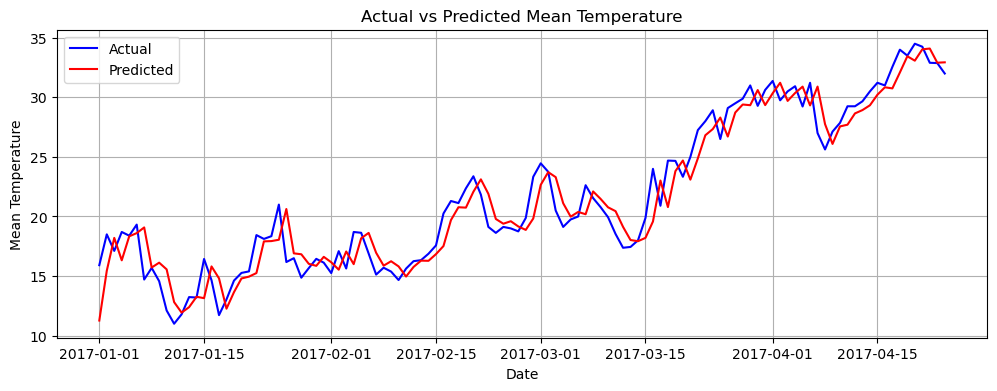

In [21]:
# Create a DataFrame for the actual and predicted values
df_pred_test = pd.DataFrame({
    'y_test': X_test,
    'y_pred': pred_wfv  # Use pred_wfv for predictions from the ARIMA model
})

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(df_pred_test.index, df_pred_test['y_test'], label='Actual', color='blue')
plt.plot(df_pred_test.index, df_pred_test['y_pred'], label='Predicted', color='red')

# Adding titles and labels
plt.title('Actual vs Predicted Mean Temperature')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()
plt.grid()
plt.show()


### Model is doing a good job in predicting the future values